In [135]:
using Catalyst, CSV, Plots, DiffEqBase, OrdinaryDiffEq, ModelingToolkit

include("./Util.jl")
include("./Reaction.jl")
include("./Network.jl")
include("./NetworkModel.jl")
include("./Rates.jl")
include("./Main.jl")

reactionsFilepath = "./input/reactions.csv"
speciesFilepath = "./input/species.csv"

reactionsData = CSV.read(reactionsFilepath, DataFrame)
speciesData = CSV.read(speciesFilepath, DataFrame)

,name,mass,natoms
,String,Int64,Int64
1,H,1,1
2,H+,1,1
3,H2,2,2
4,H2+,2,2
5,H3+,3,3
6,C,12,1
7,C+,12,1
8,CH,13,2
9,CH+,13,2


In [139]:
ICs = InitialConditions(0.1, 2.6e-4,4.6e-4,6.1e-5)
T=1. 
zeta = 1.0
F_UV=1.
A_v=1.
p = Parameters(zeta, 0.4, 0.3, T, F_UV, A_v, 0.2, 0.5)

Parameters(1.0, 0.4, 0.3, 1.0, 1.0, 1.0, 0.2, 0.5)

In [140]:
calculateRates!(reactionsData, p)
filterReactionData!(reactionsData, speciesData[!, "name"])
ENV["COLUMNS"] = 500
reactionsData[1:3,:]

,re1,re2,re3,prod1,prod2,prod3,prod4,alpha,beta,gamma,tmin,tmax,rate
,String,String,Float64,String,String,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,C,CRP,NaN,C+,E-,NAN,NaN,2.3e-17,0.0,0.0,10.0,41000.0,2.3e-17
2,CO,CRP,NaN,CO+,E-,NAN,NaN,3.9e-17,0.0,0.0,10.0,41000.0,3.9e-17
3,H2,CRP,NaN,H+,H,E-,NaN,2.86e-19,0.0,0.0,10.0,41000.0,2.86e-19


In [141]:
network = createNetworkModel(reactionsData, speciesData[!, "name"])

u0 = createU0(ICs, network)
tspan = (0.0, 10000.0)
# system = convert(ODESystem, network); throw weird error when we make the ODEProblem
prob = ODEProblem(network, u0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [0.1, 0.0, 0.0, 0.0, 0.0, 0.00026, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

 11.142149 seconds (22.84 M allocations: 870.960 MiB, 3.06% gc time)


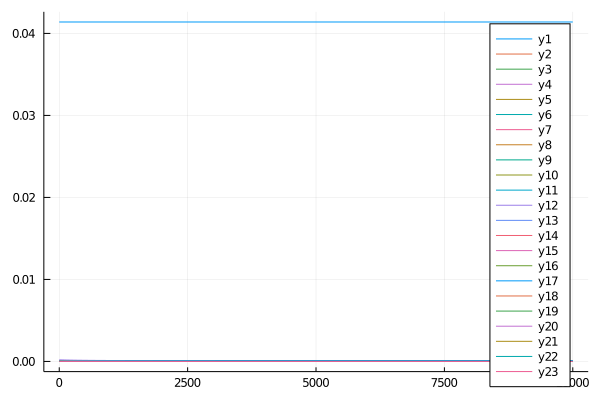

In [142]:
@time sol = solve(prob, TRBDF2(), saveat = 10.)
plotLog(x) = log10.(x .+ 1)
plot(sol.t, transpose(reduce(hcat,plotLog.(sol.u))))


In [143]:
using NeuralPDE, Flux
chain = Flux.Chain(Dense(1, 5, σ), Dense(5, 1))
opt = Flux.ADAM(0.1, (0.9, 0.95))
@time sol2 = solve(prob,
                    NeuralPDE.NNRODE(chain, opt), dt=1 / 2000f0, verbose=true,
            abstol=1e-10, maxiters=200)

 10.252320 seconds (8.56 M allocations: 438.644 MiB, 2.72% gc time)


retcode: Success
Interpolation: automatic order switching interpolation
t: 22-element Array{Float64,1}:
     0.0
     0.0005000000237487257
     0.005500000261235982
     0.05550000263610855
     0.5555000263848342
     5.555500263872091
    43.73762666898497
   139.04358440864584
   297.8198232651174
   533.139067275087
   874.7058042289989
  1330.4132959725064
  1859.2126326993548
  2482.9433925483086
  3199.6710356414233
  4003.4399989220574
  4884.594443270405
  5833.192740680759
  6840.851097843442
  7903.566085954698
  9025.633235325
 10000.0
u: 22-element Array{Array{Float64,1},1}:
 [0.1, 0.0, 0.0, 0.0, 0.0, 0.00026, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.1, 8.406667065963474e-22, 6.290428674099602e-64, 9.435643925000765e-85, 9.875516777742294e-161, 0.0002599997433764612, 3.2994839031357644e-17, 1.2999994201871959e-25, 3.4245454429881083e-38, 2.044387902810924e-88  …  1.2588531868883467e-25, 4.1226478500001223e-41, 2.1554771609272245e-76, 2.

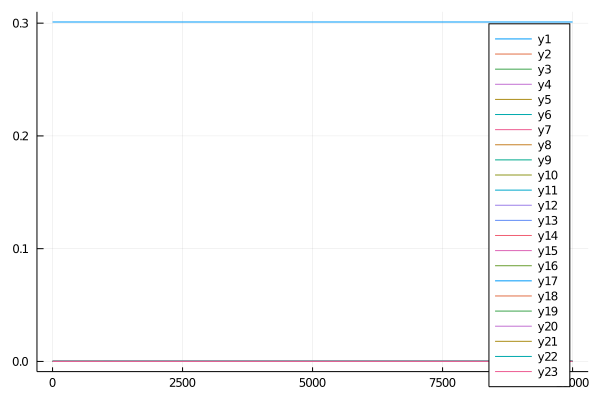

In [134]:
plot(sol2.t, transpose(reduce(hcat,plotLog.(sol2.u))))
